In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
torch.device('cuda')

device(type='cuda')

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size

        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)

            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X, Y = build_dataset(words)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [6]:
n_embd = 10
n_hidden = 64

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5 / 3) / ((n_embd * block_size) ** 0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1

bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1
# bnmean_running = torch.zeros((1, n_hidden))
# bnstd_running = torch.zeros((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))
for p in parameters: p.requires_grad = True

4073


In [8]:
# hpreact.std(0, keepdim=True)

In [8]:
batch_size = 32
n = batch_size
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [9]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [10]:
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)

# first linear layer
hprebn = embcat @ W1 + b1
# batchnorm layer
bnmeani = 1 / n * hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff ** 2
bnvar = 1 / (n - 1) * (bndiff2).sum(0, keepdim=True)
bnvar_inv = (bnvar + 1e-5) ** -0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# non linearity
h = torch.tanh(hpreact)
# second linear layer
logits = h @ W2 + b2
# cross entropy loss
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum ** -1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, norm_logits, logit_maxes, logits, h, hpreact, bnraw, bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani, embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.4619, grad_fn=<NegBackward0>)

In [50]:
# increase in max value -> decrease in normlogits
a = torch.tensor([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
], dtype=torch.float32)

b = torch.tensor([
    [2, 4, 8],
    [1, 1, 1]
], dtype=torch.float32)

b.requires_grad = True
a.requires_grad = True
c = b @ a
# c.backward()
# h.shape, W1.shape
# c1 = a
c

tensor([[ 74.,  88., 102.],
        [ 12.,  15.,  18.]], grad_fn=<MmBackward0>)

In [71]:
a = torch.tensor([
    [1, 2, 3],
    [4, 5, 6],
])
# b = torch.tensor([
#     [2, 32, 3322 ,3, 12],
#     [8, 3, 3,3,3],
#     [32,4,4,4,4],
# ])

b = torch.tensor([
    [2, 4],
    [4, 8],
    [8, 16]
])
a @ b

tensor([[ 34,  68],
        [ 76, 152]])

In [28]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

dlogprobs = torch.zeros(32, 27)
for bi in range(dlogprobs.shape[0]):
    dlogprobs[bi][Yb[bi]] = -1 / dlogprobs.shape[0]

cmp('logprobs', dlogprobs, logprobs)

dprobs = (1 / probs) * dlogprobs

cmp('probs', dprobs, probs)

dcounts_sum_inv = (counts * dprobs).sum(1, keepdims=True)

cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

dcounts_sum = -1 / (counts_sum * counts_sum) * dcounts_sum_inv

cmp('counts_sum', dcounts_sum, counts_sum)

dcounts = counts_sum_inv * dprobs
dcounts = dcounts + (torch.ones_like(counts) * dcounts_sum)

cmp('counts', dcounts, counts)

dnorm_logits = norm_logits.exp() * dcounts

cmp('norm_logits', dnorm_logits, norm_logits)

dlogit_maxes = torch.ones_like(logit_maxes) * -1 * dnorm_logits.sum(1, keepdim=True)

cmp('logit_maxes', dlogit_maxes, logit_maxes)

dlogits = dnorm_logits + dlogit_maxes

cmp('logits', dlogits, logits)

db2 = (torch.ones_like(b2) * dlogits).sum(0, keepdim=True).view(-1)
cmp('b2', db2, b2)

cmp('h', dh, h)

# cmp('W2', dW2, W2)
# cmp('hpreact', dhpreact, hpreact)
# cmp('bngain', dbngain, bngain)
# cmp('bnbias', dbnbias, bnbias)
# cmp('bnraw', dbnraw, bnraw)
# cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
# cmp('bnvar', dbnvar, bnvar)
# cmp('bndiff2', dbndiff2, bndiff2)
# cmp('bndiff', dbndiff, bndiff)
# cmp('bnmeani', dbnmeani, bnmeani)
# cmp('hprebn', dhprebn, hprebn)
# cmp('embcat', dembcat, embcat)
# cmp('W1', dW1, W1)
# cmp('b1', db1, b1)
# cmp('emb', demb, emb)
# cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: False | approximate: True  | maxdiff: 7.916241884231567e-09
torch.Size([32, 64])
b2              | exact: False | approximate: True  | maxdiff: 3.3527612686157227e-08


In [9]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi


    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    # lr = lrs[i]
    lr = 0.1 if i <= 100000 else 0.01
    # lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.2843
  10000/ 200000: 2.2819
  20000/ 200000: 2.5978
  30000/ 200000: 2.1232
  40000/ 200000: 2.2483
  50000/ 200000: 2.0076
  60000/ 200000: 2.1995
  70000/ 200000: 2.0007
  80000/ 200000: 1.9014
  90000/ 200000: 2.1583
 100000/ 200000: 1.9739
 110000/ 200000: 2.7165
 120000/ 200000: 2.1598
 130000/ 200000: 1.7619
 140000/ 200000: 1.8565
 150000/ 200000: 2.2238
 160000/ 200000: 2.1073
 170000/ 200000: 2.2235
 180000/ 200000: 1.9649
 190000/ 200000: 2.2562


torch.Size([32, 200])

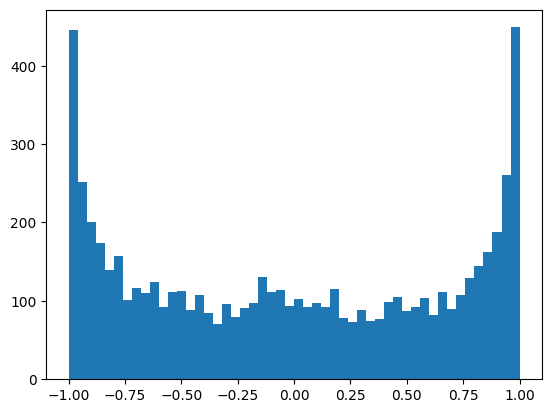

In [10]:
plt.hist(h.view(-1).tolist(), 50)
h.shape

In [11]:
logits[0]

tensor([ 2.1837,  0.6258, -0.1684,  0.1781,  0.1890,  1.8127, -1.9687, -2.6826,
        -0.2683,  1.8956, -1.2569, -0.5789,  0.5120,  1.2113,  2.4371, -0.3689,
        -1.0340, -3.6162,  2.5471,  1.5353, -0.5657, -0.1059,  0.3972, -0.6254,
        -2.8180,  1.6696, -0.9481], grad_fn=<SelectBackward0>)

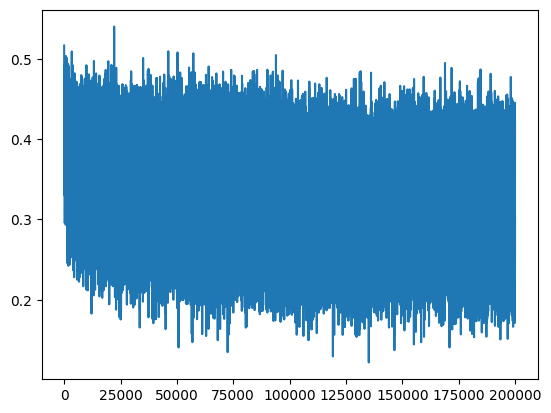

In [12]:
plt.plot(lossi)

In [13]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [14]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1

    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [15]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    # hpreact = 
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.066987991333008
val 2.104689836502075


In [20]:
for _ in range(10):
    out = []
    context = [0] * block_size

    while True:
        emb = C[torch.tensor([context])]
        # print(emb.view(-1, 30))
        # print(W1.shape)
        hpreact = emb.view(1, -1) @ W1
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        # print(logits)
        probs = F.softmax(logits, dim=1);
        ix = torch.multinomial(probs, num_samples=1).item()
        # print(probs, ix)
        # print(ix, probs[:, ix].item())
        
        prob_sum = 0
        for j in range(27):
            # print(j, itos[j], probs[:, j].item())
            prob_sum += probs[:, j].item()
        
        # print(prob_sum)
        if ix == 0:
            break

        context = context[1:] + [ix]
        out.append(ix)

    print(''.join(itos[i] for i in out))

braxandra
pawilliss
pprabnadi
keison
deventlenny
charli
jadari
deveonni
beigh
makairi
